In [1]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from statistics import mean, stdev, variance
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from collections import Counter
from sklearn.decomposition import PCA

/home/dwight/miniconda3/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [2]:
csv = pd.read_csv("monthly_data.csv")

In [3]:
num = 0
for i in range(270, 271):
    num += list(csv.isna().sum()).count(i)


In [4]:
num

4074

In [8]:
#csv = csv.drop("Unnamed: 0", axis=1)


def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        series = list_of_series[series]
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter += 1
    print(nan_polluted_series_counter)
csv.interpolate(limit_direction="both", inplace=True)
csv = csv.fillna(0)
names = csv
nan_counter(csv)

4074
0


,UNRATE,CPIAUCSL,FEDFUNDS,CSUSHPINSA,M2SL,M1SL,PSAVERT,PAYEMS,INDPRO,TB3MS,...,LAUCN310910000000004,LAUCN271470000000004,LFWATTFECAM647N,LFWA25TTCLM647N,LFWA55FECAM647S,LFWA55FEKRM647S,LFWA55MAAUM647N,LFWA55MAAUM647S,LFWA55MACLM647N,LFWA55MACLM647S
0,4.0,169.3,5.45,100.000,4666.9,1122.1,5.4,131005.0,94.1758,5.32,...,19.0,639.0,12178500.0,6230780.0,1383600.0,2.002546e+06,870032.0,868538.595538,649480.0,656664.75883
1,4.1,170.0,5.73,100.571,4680.1,1108.6,4.8,131124.0,94.4557,5.55,...,23.0,601.0,12190600.0,6230780.0,1387300.0,2.004889e+06,873052.0,873224.050233,649480.0,656664.75883
2,4.0,171.0,5.85,101.466,4710.8,1107.5,4.5,131596.0,94.7980,5.69,...,14.0,632.0,12202200.0,6230780.0,1390200.0,1.996023e+06,876073.0,876278.850327,649480.0,656664.75883
3,3.8,170.9,6.02,102.540,4766.8,1115.6,5.0,131888.0,95.4808,5.66,...,14.0,481.0,12214400.0,6230780.0,1393400.0,1.986710e+06,879073.0,878732.605495,649480.0,656664.75883
4,4.0,171.2,6.27,103.701,4754.6,1104.9,4.9,132105.0,95.6435,5.79,...,13.0,471.0,12230300.0,6230780.0,1397400.0,1.979765e+06,882076.0,882164.423297,649480.0,656664.75883


In [10]:
names = csv
scaler = MinMaxScaler()
csv = MinMaxScaler().fit_transform(csv)
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(csv))))
csv = np.transpose(csv)

In [11]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(csv))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(csv[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(csv)
som.train(csv, 50000)

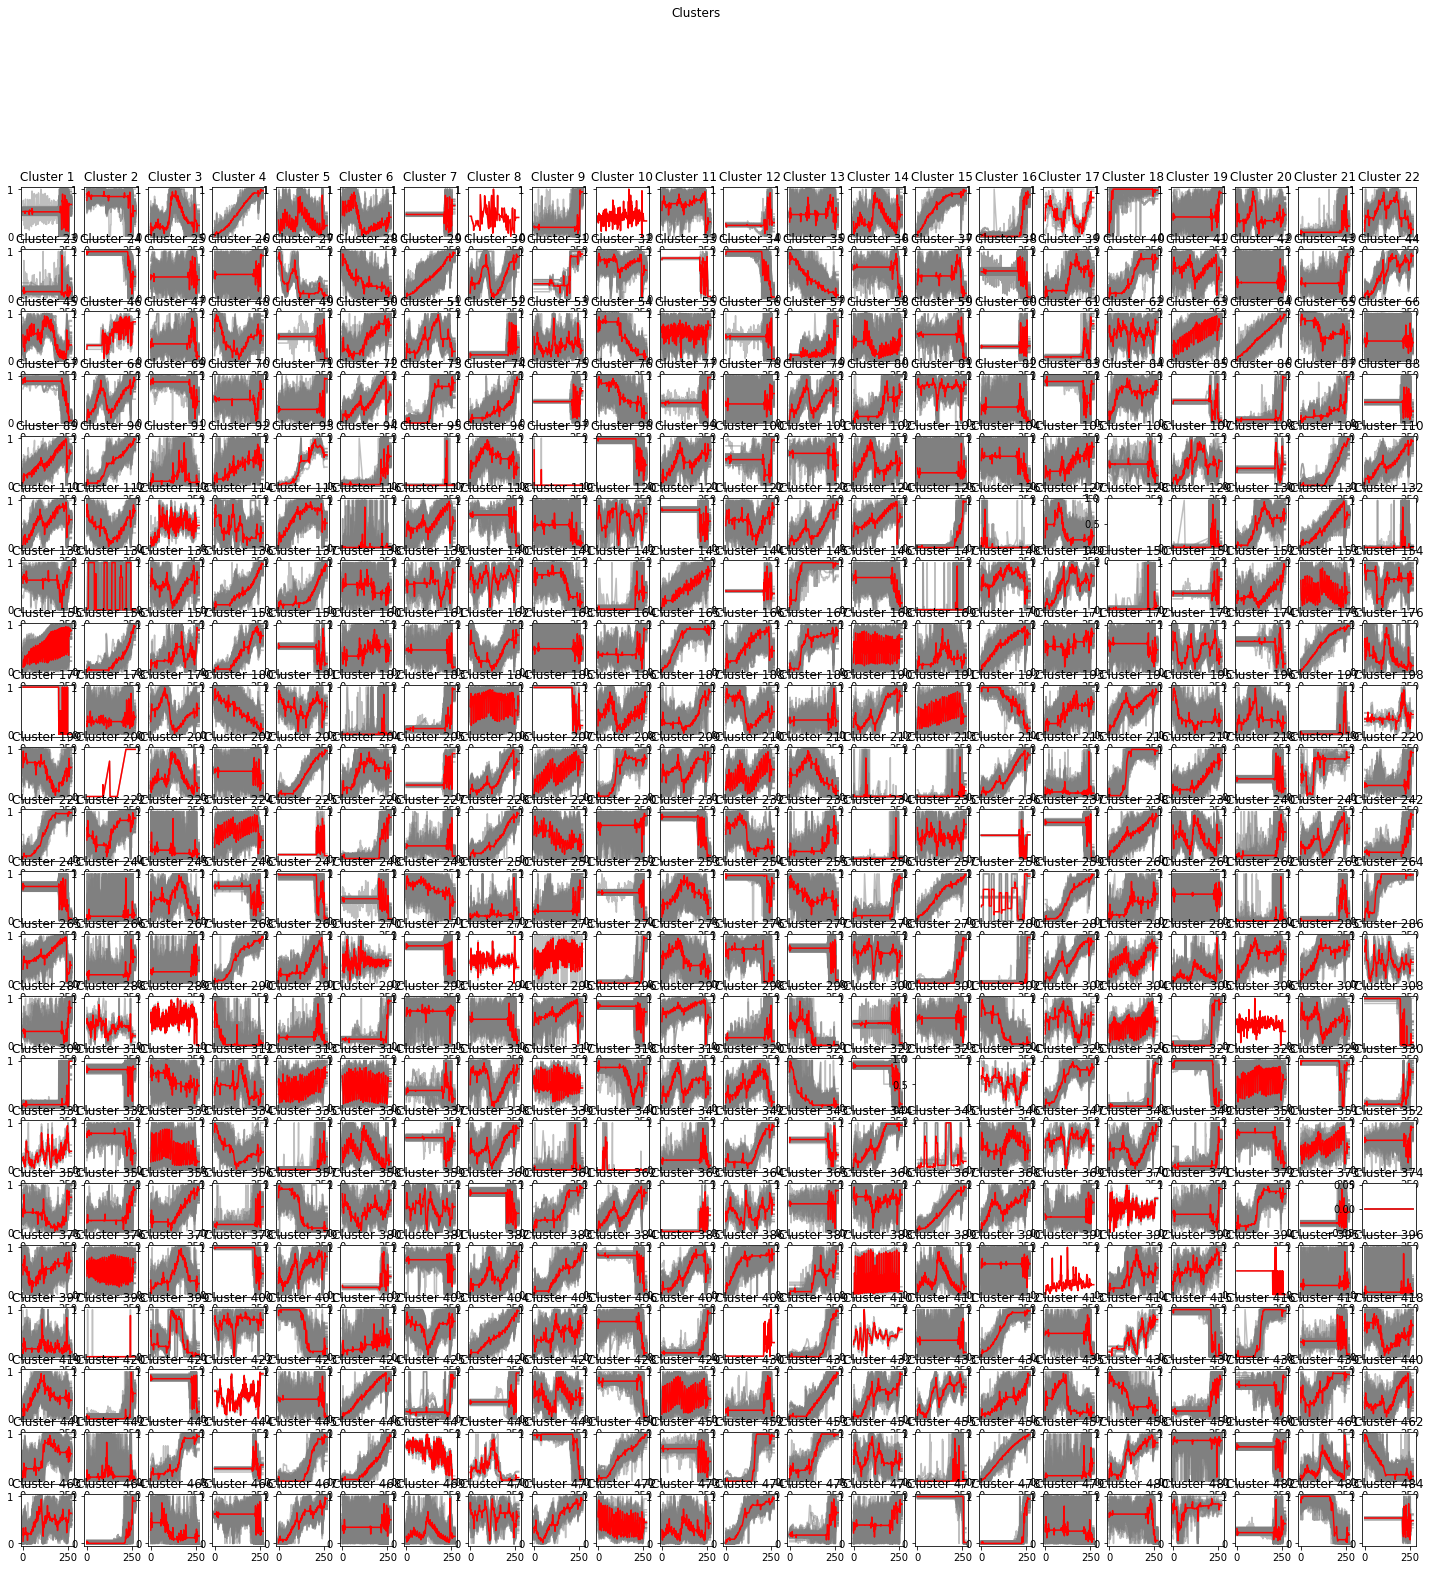

In [12]:

def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x, som_y, figsize=(25, 25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x, y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series, c="gray", alpha=0.5)
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])), c="red")  # I changed this part
            cluster_number = x * som_y + y + 1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

win_map = som.win_map(csv)
plot_som_series_dba_center(som_x, som_y, win_map)

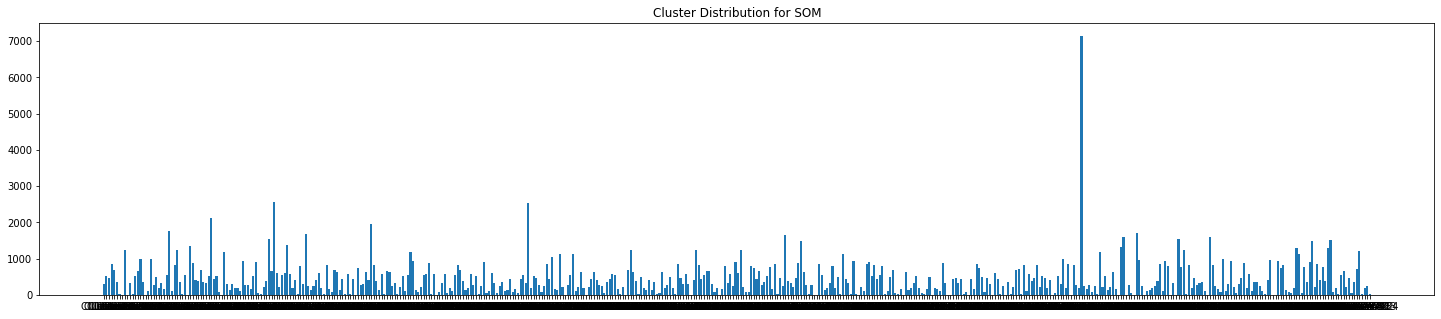

In [13]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

                            Name
Cluster                         
Cluster 1         MEDSQUFEE13780
Cluster 1     MEDOVSUSCOUNTY1009
Cluster 1         MEDSQUFEE12680
Cluster 1         NEWLISCOU20700
Cluster 1        HOSCCOUNTY42013
...                          ...
Cluster 99  SMU04000004244500001
Cluster 99  SMU48111005552000001
Cluster 99             GREE555LF
Cluster 99           JOHN747SRVO
Cluster 99      LVACP040300IXOBM

[213465 rows x 1 columns]


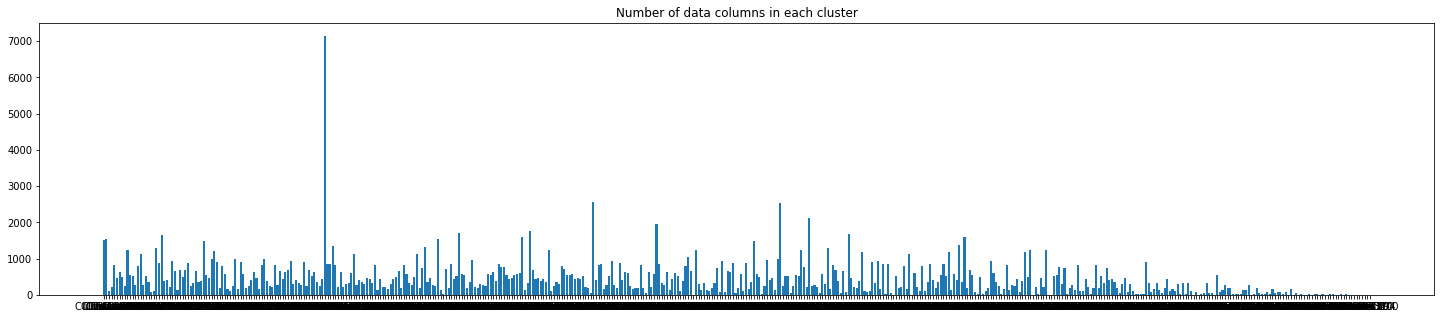

Standard Deviation of all data for Cluster 374: 81414734.21277724

Standard Deviation for means of columns for Cluster 374: 81420410.23592338


In [14]:
cluster_map = []
i = 0
cluster_x = []
cluster_dict = {}
for idx in names:
    winner_node = som.winner(csv[i])
    name = f"Cluster {winner_node[0] * som_y + winner_node[1] + 1}"
    cluster_map.append((idx, name))

    cluster_x.append(name)
    i += 1

cluster_x = Counter(cluster_x)
clusters = pd.DataFrame(cluster_map, columns=["Name", "Cluster"]).sort_values(by="Cluster").set_index("Cluster")
print(clusters)
plt.figure(figsize=(25, 5))
plt.title("Number of data columns in each cluster")
plt.bar(cluster_x.keys(), cluster_x.values())
plt.show()
datas = []
means = []
for name in clusters.loc[cluster_x.most_common()[0][0]]["Name"].values:
    data = names[name].values
    datas += list(data)
    means.append(mean(list(data)))
print(f"Standard Deviation of all data for {cluster_x.most_common()[0][0]}: {stdev(datas)}")
print(f"\nStandard Deviation for means of columns for {cluster_x.most_common()[0][0]}: {stdev(means)}")


In [ ]:
cluster_count = math.ceil(math.sqrt(len(csv))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(csv)

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(csv[i],c="gray",alpha=0.4)
                cluster.append(csv[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(csv[i],c="gray",alpha=0.4)
                cluster.append(csv[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [ ]:

cluster_map = []
i = 0
cluster_x = []
cluster_dict = {}
for idx in names:
    winner_node = som.winner(csv[i])
    name = f"Cluster {winner_node[0] * som_y + winner_node[1] + 1}"
    cluster_map.append((idx, name))

    cluster_x.append(name)
    i += 1

cluster_x = Counter(cluster_x)
clusters = pd.DataFrame(cluster_map, columns=["Name", "Cluster"]).sort_values(by="Cluster").set_index("Cluster")
print(clusters)
plt.figure(figsize=(25, 5))
plt.title("Number of data columns in each cluster")
plt.bar(cluster_x.keys(), cluster_x.values())
plt.show()
datas = []
means = []
for name in clusters.loc[cluster_x.most_common()[0][0]]["Name"].values:
    data = names[name].values
    datas += list(data)
    means.append(mean(list(data)))
print(f"Standard Deviation of all data for {cluster_x.most_common()[0][0]}: {stdev(datas)}")
print(f"\nStandard Deviation for means of columns for {cluster_x.most_common()[0][0]}: {stdev(means)}")



In [ ]:
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(csv)

In [ ]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

In [ ]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=300)
plt.show()

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(csv[i],c="gray",alpha=0.4)
                cluster.append(csv[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [ ]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()


In [ ]:
cluster_map = []
i = 0
cluster_x = []
cluster_dict = {}
for idx in names:
    winner_node = som.winner(csv[i])
    name = f"Cluster {winner_node[0] * som_y + winner_node[1] + 1}"
    cluster_map.append((idx, name))

    cluster_x.append(name)
    i += 1

cluster_x = Counter(cluster_x)
clusters = pd.DataFrame(cluster_map, columns=["Name", "Cluster"]).sort_values(by="Cluster").set_index("Cluster")
print(clusters)
plt.figure(figsize=(25, 5))
plt.title("Number of data columns in each cluster")
plt.bar(cluster_x.keys(), cluster_x.values())
plt.show()
datas = []
means = []
for name in clusters.loc[cluster_x.most_common()[0][0]]["Name"].values:
    data = names[name].values
    datas += list(data)
    means.append(mean(list(data)))
print(f"Standard Deviation of all data for {cluster_x.most_common()[0][0]}: {stdev(datas)}")
print(f"\nStandard Deviation for means of columns for {cluster_x.most_common()[0][0]}: {stdev(means)}")
